### Install Dependency

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.1+cu118
11.8
True


### Ticker

In [4]:
ticker_symbol = "NVDA"

### Data Collection

In [5]:
import pandas as pd

df = pd.read_csv(f'../data/{ticker_symbol}.csv')

### Prepare Data

In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
       'MACD_signal', 'MACD_hist', 'BB_upper', 'BB_middle', 'BB_lower',
       'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Close_rolling_mean_5'],
      dtype='object')

In [7]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist',
    'BB_upper', 'BB_middle', 'BB_lower',
    'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
    'Close_rolling_mean_5'
]
target = 'Close'

In [8]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features + [target]])

In [9]:
X = []
y = []
seq_len = 10

for i in range(seq_len, len(scaled)):
    X.append(scaled[i - seq_len:i, :-1])  # all features except target
    y.append(scaled[i, -1])               # target = next day's Close

X = np.array(X)
y = np.array(y)

### Dataset and Dataloader

In [29]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [30]:
split = int(0.8 * len(X))

train_ds = StockDataset(X[:split], y[:split])
test_ds = StockDataset(X[split:], y[split:])

In [31]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

### Define LSTM Model

In [24]:
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # only last time step
        return out.squeeze()


In [25]:
model = LSTMModel(input_size=X.shape[2])

### Train the Model

In [27]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
for epoch in range(50):
    model.train()
    epoch_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_dl):.4f}")

Epoch 1, Loss: 0.0069
Epoch 2, Loss: 0.0578
Epoch 3, Loss: 0.0214
Epoch 4, Loss: 0.0011
Epoch 5, Loss: 0.0018
Epoch 6, Loss: 0.0022
Epoch 7, Loss: 0.0021
Epoch 8, Loss: 0.0021
Epoch 9, Loss: 0.0022
Epoch 10, Loss: 0.0022
Epoch 11, Loss: 0.0023
Epoch 12, Loss: 0.0025
Epoch 13, Loss: 0.0027
Epoch 14, Loss: 0.0030
Epoch 15, Loss: 0.0035
Epoch 16, Loss: 0.0041
Epoch 17, Loss: 0.0048
Epoch 18, Loss: 0.0052
Epoch 19, Loss: 0.0041
Epoch 20, Loss: 0.0029
Epoch 21, Loss: 0.0055
Epoch 22, Loss: 0.0044
Epoch 23, Loss: 0.0012
Epoch 24, Loss: 0.0047
Epoch 25, Loss: 0.0017
Epoch 26, Loss: 0.0007
Epoch 27, Loss: 0.0007
Epoch 28, Loss: 0.0007
Epoch 29, Loss: 0.0007
Epoch 30, Loss: 0.0007
Epoch 31, Loss: 0.0006
Epoch 32, Loss: 0.0006
Epoch 33, Loss: 0.0005
Epoch 34, Loss: 0.0005
Epoch 35, Loss: 0.0005
Epoch 36, Loss: 0.0005
Epoch 37, Loss: 0.0005
Epoch 38, Loss: 0.0004
Epoch 39, Loss: 0.0004
Epoch 40, Loss: 0.0005
Epoch 41, Loss: 0.0005
Epoch 42, Loss: 0.0006
Epoch 43, Loss: 0.0006
Epoch 44, Loss: 0.00

### Evaluate & Plot

In [35]:
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        pred = model(xb)  # shape: (batch_size,)
        preds.extend(pred.cpu().view(-1).numpy())      # flatten and collect
        actuals.extend(yb.cpu().view(-1).numpy())

# Convert to proper 2D shape
preds = np.array(preds).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

# Invert scaling using dummy feature vectors (zeros for all input features)
blank = np.zeros((len(preds), len(features)))  # same as X.shape[2]
reconstructed_pred = scaler.inverse_transform(np.hstack([blank, preds]))[:, -1]
reconstructed_true = scaler.inverse_transform(np.hstack([blank, actuals]))[:, -1]


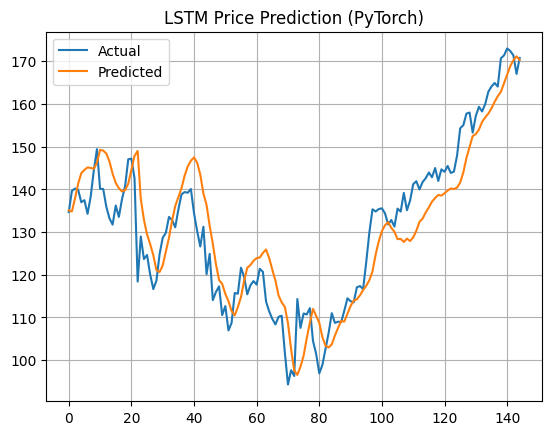

In [38]:
import matplotlib.pyplot as plt
plt.plot(reconstructed_true, label='Actual')
plt.plot(reconstructed_pred, label='Predicted')
plt.legend()
plt.title("LSTM Price Prediction (PyTorch)")
plt.grid()
plt.show()

### Predict Next Day

In [39]:
last_seq = df[features].iloc[-10:].values

In [40]:
dummy_close = df["Close"].iloc[-10:].values.reshape(-1, 1)
last_seq_scaled = scaler.transform(np.hstack([last_seq, dummy_close]))[:, :-1]

f:\GitHub\Magnificent_7_Analysis\dev\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [41]:
input_tensor = torch.tensor(last_seq_scaled, dtype=torch.float32).unsqueeze(0).to(device)

In [42]:
model.eval()
with torch.no_grad():
    pred_scaled = model(input_tensor).cpu().numpy().reshape(-1, 1)

# Inverse transform
blank = np.zeros((1, len(features)))
reconstructed = scaler.inverse_transform(np.hstack([blank, pred_scaled]))
next_day_close = reconstructed[0, -1]

In [43]:
print(f"Predicted Close Price for Tomorrow: {next_day_close:.2f}")

Predicted Close Price for Tomorrow: 170.37
